Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

## Задачи:
- В первую очередь, его интересует показатель retention.
Напишите функцию для его подсчета.
- Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
- Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

## Результаты:
### Retention
Для расчёт retention было написано две функции:
 - **Функция расчёта retention для определённого дня: get_nday_retention**
 
Что функция принимает?
- датафрейм 
- n: день, по который следует посчитать retention. 
- start_date: с какой когорты начать, принимает дату вида '2020-05-12'
- end_date: на какой когорте закончить,  принимает дату вида '2020-05-12'
- hm: хитмап с когортой и retention с day_1 по day_n, принимает значения True или False

Возвращает датафрейм, состоящий из:
 - cohort: когорты
 - users: количество юзеров в когорте
 - day_n: значение дня n, переданного функции
 - active_users: аобсолютное число активных пользователей в день n для когорты
 - retention: retention для этого дня для каждой из когорт
 - rolling retention: rolling retention для этого дня для каждой из когорт
 - Если hm = True, возвращает хитмап с когортой и retention day_n


 - **Функция расчёта retention до дня n: get_ndays_retention**
 
Что функция принимает?
- датафрейм 
- n: день, по который следует посчитать retention. 
- start_date: с какой когорты начать, принимает дату вида '2020-05-12'
- end_date: на какой когорте закончить,  принимает дату вида '2020-05-12'
- hm: хитмап с когортой и retention с day_1 по day_n, принимает значения True или False

Возвращает датафрейм, состоящий из:
 - cohort: когорты
 - users: количество юзеров в когорте
 - day_1 - day_n: retention дня n для каждой из когорт
 - rolling retention: rolling retention дня n для каждой из когорт
 - Если hm = True, возвращает хитмап с когортой и retention с day_1 по day_n
 
 
### AB, выбранные метрики: CR в покупателя, ARPPU, перепроверка ARPU
 **CR в покупателя**

- В контрольной группе есть кластер юзеров, которые платят значительно больше остальных. Этот кластер составляет 6% наблюдений от общего чила наблюдений в контрольной группе. В тестовой группе этот кластер пропадает, остаётся только равномерное распределение более-менее средних покупателей. Разница между числом покупателей в тестовой и контрольной группах статистически значима, проверялась с помощью хи-квадрат.

**ARPPU**
- Контрольная группа включает в себя как кластер средних покупателей, которые заплатили немного, но более-менее одинаково и кластер юзеров, заплативших много. Тестовая группая представляет из себя равномерное распределение, но доход с одного юзера в среднем в 10 раз больше, чем доход со среднего юзера в контрольной выборке (200-400 и 2000-4000).
- Если считать кластер упомянутый выше не выбросом, и оставить данные как есть, бутстрап говорит об отсуствии статистически значимой разницы  для ARPPU по выборкам. 
- Медианы по RPPU различаются, что ожидаемо, в пользу контрольной группы.

**Перепроверка ARPU**
- Так как результаты показались неоднозначными, я решила перепроварить результаты работы прошлого аналитика. Для ARPU по полнным данным бустрап не выявил статистически значимой разницы.
- Для ARPU с исключением из контрольной выборки кластера самых доходных юзеров статистически значимая разница есть, но она не равна 5% : в таком случае средняя тестовой группы примеро в 9 раз выше средней контрольной.

**Что делать?**

**Я считаю, что фичу не нужно выкатывать** : в контрольной группе есть кластер юзеров, которые платят значительно больше остальных, и именно эти наблюдения пропадают: разница между числом покупателей в тестовой и контрольной группах статистически значима, проверялась с помощью хи-квадрат.

ARPPU и ARPU статистически значимо не различаются.

Тут можно добавить, что в тестовой группе выше медиана RPPU, то есть средний пользователь тратит больше, чем в контрольной. Но нужно ли нам это, учитывая то, что вместе с тем пропал кластер самых доходных пользователей? Я считаю, что нет.

### Задание 3 
Описано в конце документа

Импорт всех необходимых библиотек для заданий:

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats  import chi2_contingency
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
from tqdm.auto import tqdm

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    # нам нужно сравнять количество наблюдений в обоих выборках, чтобы метод сработал
    boot_len = max([len(data_column_1), len(data_column_2)])
    # пустой список, в который будет записано нужное нам распределение
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
    # рассчитываем доверительный интервал. Если 0 не попадает в ДИ, отклоняем H0  
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    # так как нас интересуют значения выше нуля  
    p_value = min( sum(pd_boot_data < 0), sum(pd_boot_data > 0) ) * 2 / len(pd_boot_data)
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [3]:
#Стиль графиков
sns.set (
    font_scale =1.5,
    style = 'whitegrid',
    rc= {'figure.figsize': (25,7)}
)

In [4]:
#функция для получения shape, types и количества NAN в колонках
def get_info(df):
    shape = df.shape
    types = df.dtypes
    isna_sum = df.isna().sum()
    dict = {"shape": shape, "types":types, "NAN" : isna_sum}
    return dict

### Расчёт retention

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные имеют следующую структуру:

reg_data.csv – данные о времени регистрации

auth_data.csv – данные о времени захода пользователей в игру

#### Общий обзор данных:

In [5]:
df_reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-bataeva/shared/problem1-reg_data.csv', sep = ';')
df_auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-bataeva/shared/problem1-auth_data.csv', sep = ';')

In [6]:
df_reg_data.head(3)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3


In [7]:
get_info(df_reg_data)

{'shape': (1000000, 2),
 'types': reg_ts    int64
 uid       int64
 dtype: object,
 'NAN': reg_ts    0
 uid       0
 dtype: int64}

In [8]:
df_reg_data.uid.nunique()

1000000

In [9]:
df_auth_data.head(3)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2


In [10]:
get_info(df_auth_data)

{'shape': (9601013, 2),
 'types': auth_ts    int64
 uid        int64
 dtype: object,
 'NAN': auth_ts    0
 uid        0
 dtype: int64}

In [11]:
df_auth_data.auth_ts.nunique()

9180915

Добавляю колонку с временем в формате даты; в частности, в дф с регистрацией добавляю когорту

In [12]:
df_reg_data['cohort'] = pd.to_datetime(df_reg_data.reg_ts,  unit='s').dt.date #здесь получается тип object
df_reg_data['cohort'] = pd.to_datetime(df_reg_data['cohort']) #окончательно в datetime

df_auth_data['auth_date'] = pd.to_datetime(df_auth_data.auth_ts, unit='s').dt.date
df_auth_data['auth_date']  = pd.to_datetime(df_auth_data['auth_date'])

In [13]:
df_full = df_reg_data.merge(df_auth_data, how= 'left')

In [14]:
df_full.head(3)

,reg_ts,uid,cohort,auth_ts,auth_date
0,911382223,1,1998-11-18,911382223,1998-11-18
1,932683089,2,1999-07-22,932683089,1999-07-22
2,932683089,2,1999-07-22,932921206,1999-07-25


In [15]:
users_by_cohorts = df_full.groupby('cohort').uid.nunique().to_frame().reset_index() \
    .rename(columns = {'uid':'users'})

In [16]:
users_by_cohorts.head()

,cohort,users
0,1998-11-18,1
1,1999-07-22,1
2,2000-01-13,1
3,2000-05-28,1
4,2000-09-16,1


Так как данных слишком много, беру только часть дф, чтобы быстрее считалось

In [17]:
users_by_cohorts = users_by_cohorts.query('cohort > "2020-05-11"')

Полный датафрем, готовый для работы функции:

In [18]:
df_full = df_full.merge(users_by_cohorts)

In [19]:
df_full.head()

,reg_ts,uid,cohort,auth_ts,auth_date,users
0,1589241631,890013,2020-05-12,1589241631,2020-05-12,1319
1,1589241631,890013,2020-05-12,1589530312,2020-05-15,1319
2,1589241631,890013,2020-05-12,1589947113,2020-05-20,1319
3,1589241631,890013,2020-05-12,1590403965,2020-05-25,1319
4,1589241631,890013,2020-05-12,1590807072,2020-05-30,1319


### Функция расчёта retention для определённого дня: get_nday_retention

Что функция принимает?
- датафрейм 
- n: день, по который следует посчитать retention. 
- start_date: с какой когорты начать, принимает дату вида '2020-05-12'
- end_date: на какой когорте закончить,  принимает дату вида '2020-05-12'
- hm: хитмап с когортой и retention с day_1 по day_n, принимает значения True или False

Возвращает датафрейм, состоящий из:
 - cohort: когорты
 - users: количество юзеров в когорте
 - day_n: значение дня n, переданного функции
 - active_users: аобсолютное число активных пользователей в день n для когорты
 - retention: retention для этого дня для каждой из когорт
 - rolling retention: rolling retention для этого дня для каждой из когорт
 - Если hm = True, возвращает хитмап с когортой и retention day_n

In [49]:
def get_nday_retention(df_full, n, start_date = '2020-05-12', end_date = '2020-09-23', hm = False):
    
    lst = [] #список для значений от каждой итрерации: из него потом собирается дф
    freq = 'D' #временной промежуток: по дням
    
    start_date = start_date # с какой когорты начать
    end_date = end_date # какой когортой закончить
    df_full = df_full.query('cohort >= @start_date & cohort <= @end_date') #отбор когорт по указанному интервалу
    
    unique_cohorts = df_full.cohort.drop_duplicates() # оставляю только уникальные когорты
    
    for current_cohort in unique_cohorts:

        #сама когорта, список айди когорты
        users = df_full.query('cohort == @current_cohort').users.values[0]   # кол-во юзеров в когорте 
        n_day = current_cohort + pd.Timedelta(n, unit=freq )  # считаю n day дату
        users_list = df_full.query('cohort == @current_cohort').uid.unique().tolist() # список айди юзеров когорты

        #данные пользователей когорты в день n
        day_n_df = df_full.query('auth_date == @n_day') # получаю кусок дф с данными активности в день n
        n_day_users_count = day_n_df.query('uid in @users_list').uid.nunique() # число активных пользователей из когорты в день n

        #retention
        retention = ((n_day_users_count/ users) * 100).round(1) # retention для дня n


        #rolling retention
        rolling_retention = 0

        for day in range(1, n + 1):
            n_day_roll = current_cohort + pd.Timedelta(day, unit=freq )  # считаю n day дату
            day_n_roll_df = df_full.query('auth_date == @n_day_roll') # получаю кусок дф с данными активности в день n
            n_day_users_count_roll = day_n_roll_df.query('uid in @users_list').uid.nunique() # число активных пользователей из когорты в день n

            rolling_retention = (rolling_retention + (n_day_users_count_roll / users) * 100).round(1)


        #передаю найденные значения в списки для дф
        values_list = [current_cohort, users, n, n_day_users_count ,retention, rolling_retention]
        lst.append(values_list)  

        #собираю дф
    retention_df = pd.DataFrame(lst, columns =['cohort', 'users', 'n_day', 'active_users', 'retention', 'rolling_retention'])

    if hm == False:
        
        return retention_df
    
    if hm == True:
        
        #отрисовка хм
        cm = retention_df.set_index('cohort').drop(columns = ['users', 'n_day', 'active_users', 'rolling_retention']).values #сами значения для тела хм
        df_cm = retention_df.set_index('cohort').drop(columns = ['users', 'n_day', 'active_users', 'rolling_retention']) #отсюда возьму колонки для осей хм
        hm = sns.heatmap(cm, cmap="YlGnBu", annot=True, fmt='.2f', annot_kws={'size': 10}, xticklabels = df_cm.columns.values, \
                         yticklabels =df_cm.index.values)
        
        return hm

In [50]:
get_nday_retention(df_full, 7, start_date = '2020-05-12', end_date = '2020-05-26', hm = False)

,cohort,users,n_day,active_users,retention,rolling_retention
0,2020-05-12,1319,7,68,5.2,32.0
1,2020-05-13,1321,7,60,4.5,34.8
2,2020-05-14,1323,7,85,6.4,37.9
3,2020-05-15,1326,7,78,5.9,31.9
4,2020-05-16,1327,7,63,4.7,31.4
5,2020-05-17,1330,7,73,5.5,35.9
6,2020-05-18,1332,7,82,6.2,35.5
7,2020-05-19,1334,7,74,5.5,35.4
8,2020-05-20,1336,7,74,5.5,36.8
9,2020-05-21,1339,7,93,6.9,31.7


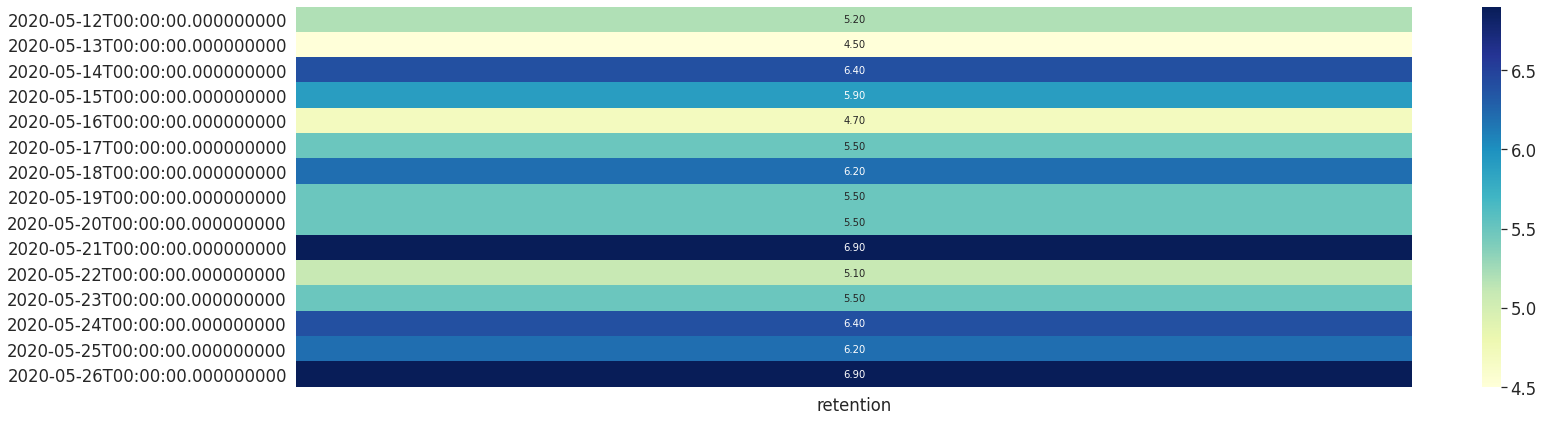

In [51]:
get_nday_retention(df_full, 7, start_date = '2020-05-12', end_date = '2020-05-26', hm = True)

### Функция расчёта retention до дня n: get_ndays_retention

Что функция принимает?
- датафрейм 
- n: день, по который следует посчитать retention. 
- start_date: с какой когорты начать, принимает дату вида '2020-05-12'
- end_date: на какой когорте закончить,  принимает дату вида '2020-05-12'
- hm: хитмап с когортой и retention с day_1 по day_n, принимает значения True или False

Возвращает датафрейм, состоящий из:
 - cohort: когорты
 - users: количество юзеров в когорте
 - day_1 - day_n: retention дня n для каждой из когорт
 - rolling retention: rolling retention дня n для каждой из когорт
 - Если hm = True, возвращает хитмап с когортой и retention с day_1 по day_n

In [42]:
def get_ndays_retention(df_full, n, start_date = '2020-05-12', end_date = '2020-09-23', hm = False):    
    lst = [] #список для значений от каждой итрерации: из него потом собирается дф
    n_day_retentions = [] #список retention по дням
    values_list = [] # список для строк будущего датасета
    freq = 'D' #временной промежуток: по дням
    
    start_date = start_date # с какой когорты начать
    end_date = end_date # какой когортой закончить
    df_full = df_full.query('cohort >= @start_date & cohort <= @end_date') #отбор когорт по указанному интервалу
    unique_cohorts = df_full.cohort.drop_duplicates() # оставляю только уникальные когорты

    for current_cohort in unique_cohorts:

        #сама когорта, список айди когорты
        users = df_full.query('cohort == @current_cohort').users.values[0]   # кол-во юзеров в когорте 
        n_day = current_cohort + pd.Timedelta(n, unit=freq )  # считаю n day дату
        users_list = df_full.query('cohort == @current_cohort').uid.unique().tolist() # список айди юзеров когорты    

        values_list.extend([current_cohort, users]) #сразу добавляю первые значения, так как это удобнее в данном случае

        #rolling retention
        rolling_retention = 0

        #расчёт retention для каждого дня до дня n
        for day in range(1, n + 1):

            #расчёт когорты дня n
            n_day_roll = current_cohort + pd.Timedelta(day, unit=freq )  # считаю n day дату
            day_n_roll_df = df_full.query('auth_date == @n_day_roll') # получаю кусок дф с данными активности в день n
            n_day_users_count_roll = day_n_roll_df.query('uid in @users_list').uid.nunique() # число активных пользователей из когорты в день n

            #расчёт retention дня n
            n_day_retention = ((n_day_users_count_roll / users) * 100).round(1) 
            n_day_retentions.append(n_day_retention) #добавляю значение к списке для retention по каждому дню

            values_list.append(n_day_retention) #сразу добавляю первые значения, так как это удобнее в данном случае


            rolling_retention = (rolling_retention + (n_day_users_count_roll / users) * 100).round(1)


        #передаю найденные значения в списки для дф
        values_list.append(rolling_retention)
        lst.append(values_list) 
        values_list = [] #обнуляю список, чтобы не перезаписывалось лишнее


        #так как количество дней будет разными, и от этого зависит количество колонок, создаю цикл для именования колонок по дням
        days = []
    for day in range(1, n + 1):
        day = 'day_' + str(day) 
        days.append(day)

    #финальные названия колонок    
    columns =[]    
    columns.extend(('cohort', 'users'))
    columns.extend(days)
    columns.append('rolling_retention')

    #формирую сам дф
    retention_df = pd.DataFrame(lst, columns =columns)
    
    if hm == False:
        
        return retention_df
    
    if hm == True:
        
        #отрисовка хм
        cm = retention_df.set_index('cohort').drop(columns = ['users','rolling_retention']).values #сами значения для тела хм
        df_cm = retention_df.set_index('cohort').drop(columns = ['users','rolling_retention']) #отсюда возьму колонки для осей хм
        hm = sns.heatmap(cm, cmap="YlGnBu", annot=True, fmt='.2f', annot_kws={'size': 10}, xticklabels = df_cm.columns.values, \
                         yticklabels =df_cm.index.values)
        
        return hm

In [43]:
get_ndays_retention(df_full, 7, start_date = '2020-05-12', end_date = '2020-05-26', hm = False)

,cohort,users,day_1,day_2,day_3,day_4,day_5,day_6,day_7,rolling_retention
0,2020-05-12,1319,1.1,4.6,4.1,5.1,6.1,5.8,5.2,32.0
1,2020-05-13,1321,2.6,3.3,4.9,6.1,5.7,7.7,4.5,34.8
2,2020-05-14,1323,2.9,4.1,5.7,5.3,6.5,7.0,6.4,37.9
3,2020-05-15,1326,1.7,3.9,4.4,4.5,5.0,6.5,5.9,31.9
4,2020-05-16,1327,1.7,3.8,5.0,3.9,6.3,6.0,4.7,31.4
5,2020-05-17,1330,1.8,4.4,5.2,6.9,5.6,6.5,5.5,35.9
6,2020-05-18,1332,2.0,4.3,4.4,6.4,5.9,6.3,6.2,35.5
7,2020-05-19,1334,2.1,3.8,5.1,6.1,6.3,6.5,5.5,35.4
8,2020-05-20,1336,2.1,4.5,5.3,4.9,7.9,6.6,5.5,36.8
9,2020-05-21,1339,1.2,3.4,4.2,4.2,6.3,5.5,6.9,31.7


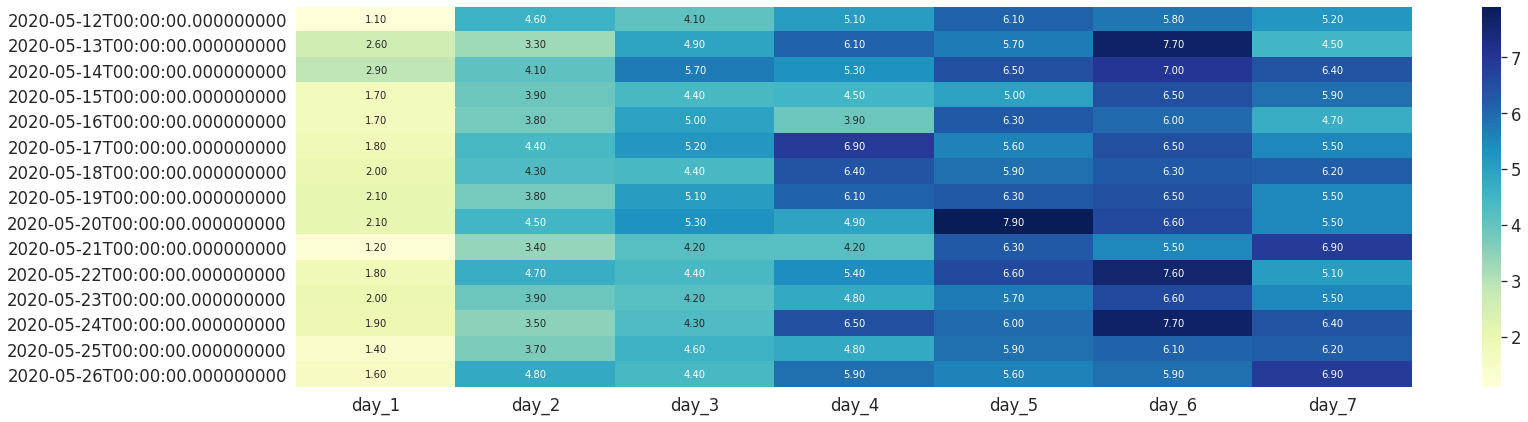

In [44]:
get_ndays_retention(df_full, 7, start_date = '2020-05-12', end_date = '2020-05-26', hm = True)

### Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

### Решение

Что ж, первым делом хочется посмотреть на сами данные, особенно на распределение платящих в обеих группах. ARPU - это, конечно, хорошо, но, учитывая, что в выборках много неплатящих пользователей, следует посмотреть ещё 
- ARPPU
- CR в покупателя.

Читаю данные, смотрю их свойства:

In [7]:
df_ab_test = pd.read_csv('Проект_1_Задание_2.csv', sep = ';')
df_ab_test.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [8]:
get_info(df_ab_test)

{'shape': (404770, 3),
 'types': user_id       int64
 revenue       int64
 testgroup    object
 dtype: object,
 'NAN': user_id      0
 revenue      0
 testgroup    0
 dtype: int64}

С типами всё в порядке, пропусков нет

Смотрю самую общую информацию о данных:

Все ли айдишники уникальные?

In [9]:
df_ab_test.user_id.nunique() == df_ab_test.shape[0]

True

Отлично.

Теперь хочется посмотреть самую общую информацию о данных в обеих группах. Для этого я перегруппирую дф, и после применю describe

In [10]:
pivoted_ab_df = pd.pivot_table(data = df_ab_test, index = 'user_id', columns = 'testgroup', values = 'revenue')

In [11]:
pivoted_ab_df.head()

testgroup,a,b
user_id,,
1,NaN,0.0
2,0.0,NaN
3,0.0,NaN
4,NaN,0.0
5,NaN,0.0


In [12]:
pivoted_ab_df.describe()

testgroup,a,b
count,202103.000000,202667.000000
mean,25.413720,26.751287
std,920.768137,287.324162
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,37433.000000,4000.000000


Что можно сказать сразу:

    1. В группе А есть как минимум один серьёзный выброс
    2. Что любопытно, средние при этом не выглядят сильно разными: судя по выбросу и значению std, в контрольной группе дисперсия выше
    3. Едва ли распределения ARPU и ARPPU будут нормальными

Как это выглядит на графике?

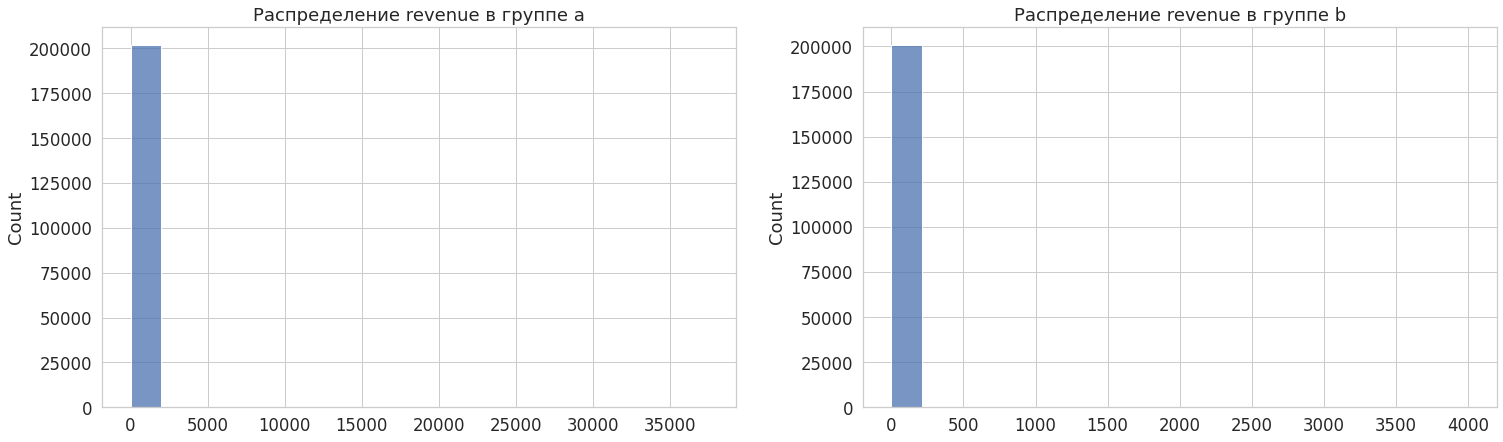

In [13]:
fig, ax = plt.subplots(1, 2)
sns.histplot(pivoted_ab_df.a, ax=ax[0])
sns.histplot(pivoted_ab_df.b, ax=ax[1])
ax[0].set_title('Распределение revenue в группе a')
ax[0].set_xlabel('')
ax[1].set_title('Распределение revenue в группе b')
ax[1].set_xlabel('')
plt.show()

Ожидаемо: большое количество нулевых или близких к нулю значений и редкие выбросы.

Каков был суммарный доход с каждой из групп?

In [16]:
print('sum_revenue_a =', pivoted_ab_df.a.sum())

sum_revenue_a = 5136189.0


In [17]:
print('sum_revenue_b =', pivoted_ab_df.b.sum())

sum_revenue_b = 5421603.0


В абсолютных значения от контрольной группы пришло больше денег, но пока это не проверено статистически, это просто числа

**Теперь можно перейти к оценке метрик!**

### CR в покупателя

Хочется узнать, есть ли статистически значимая разница между количеством платящих в тестовой и контрольной группах


In [18]:
pd.crosstab(columns = df_ab_test.revenue >0, index =  df_ab_test.testgroup)

revenue,False,True
testgroup,,
a,200175,1928
b,200862,1805


In [19]:
chi2, p =  chi2_contingency(pd.crosstab(columns = df_ab_test. testgroup, index = df_ab_test.revenue >0 ))[:2]
print('chi2 =', chi2)
print('p_value =', p)

chi2 = 4.374729521260405
p_value = 0.03647561892312613


#### Вывод по CR в покупателя:
p =0.036, Взаимосвязь между группой и количеством платящих есть. В нашем конкретном случае в контрольной группе оказалось больше платящих пользователей, чем в контрольной.

### ARPPU


Далее посмотрим на распределения платящих в обеих группах!

In [20]:
#для проверки нормальности
def normality_test(df):     
    s = stats.shapiro(df)
    return s, df.hist()

Создаю отдельные выборки платящих для контрольной и тестовой групп

In [21]:
df_a= df_ab_test.query('testgroup == "a" & revenue > 0')
df_b= df_ab_test.query('testgroup == "b" & revenue > 0')

In [22]:
df_a.describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


In [23]:
df_b.describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


Что можно сказать сразу:

    1. Медианы в группах различаются сильнее, чем средние! 
    2. RPPU в контрольной группе больше похоже RPU - много небольших значений, есть выброс. В тестовой ближе к равномерному

Графики вместе с Шапиро тестом:

(ShapiroResult(statistic=0.2667924761772156, pvalue=0.0),
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9e5a97c048>)

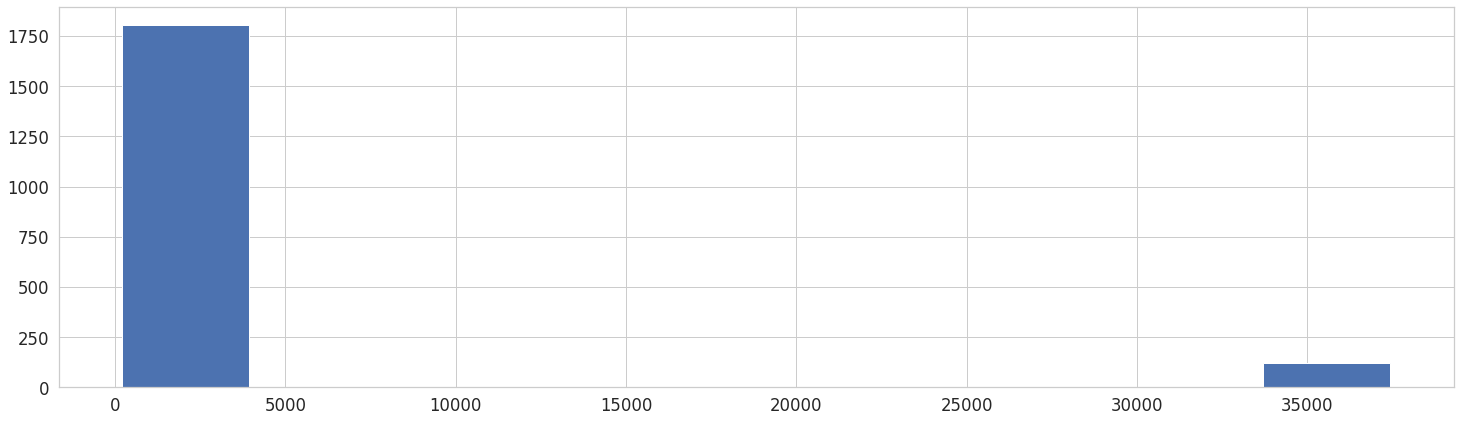

In [24]:
normality_test(df_a.revenue)

(ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22),
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9e5a8f9668>)

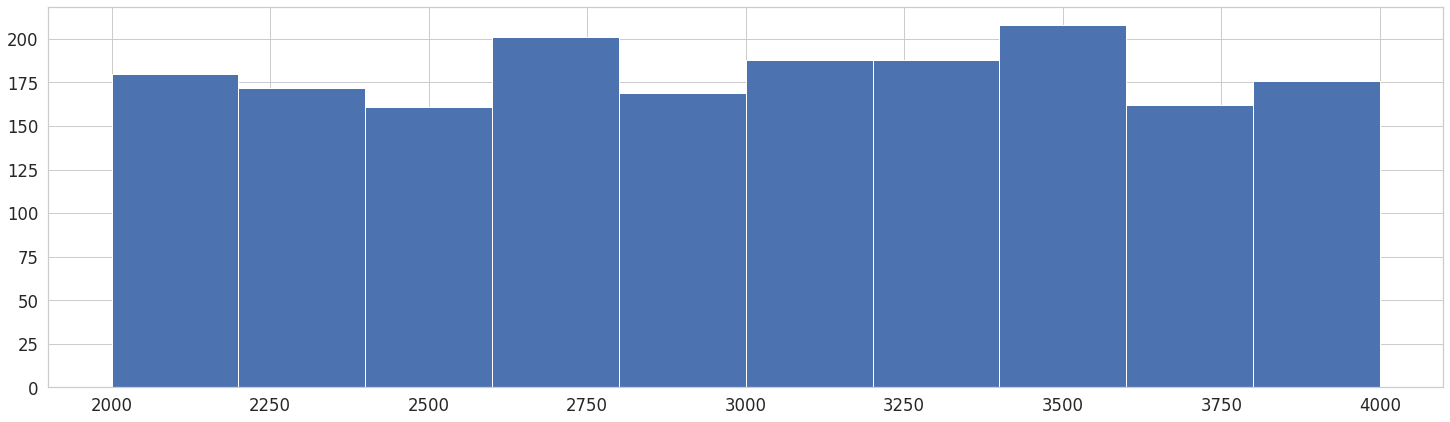

In [25]:
normality_test(df_b.revenue)

Визуально видно, что оба распределения не являются нормальными, хотя для первого Шапиро и показали p< 0.05, и мы ему не поверим. Как видно, в контрольной группе есть небольшая выборка людей, которая заплатила в районе 35к рублей. Так как их несколько, их вряд ли можно посчитать неинформативными данными, потому я решила, что оставлю их в выборке. Хотя и заметно, что без этих наблюдений распределение контрольной группы так же станет равномерным, как и в тестовой, но с намного меньшими значениями. Рапсределение RPPU в тестовой равномерное, интервал от 2000 до 4000 

Посмотрим распределение контрольной группы без больших покупателей:

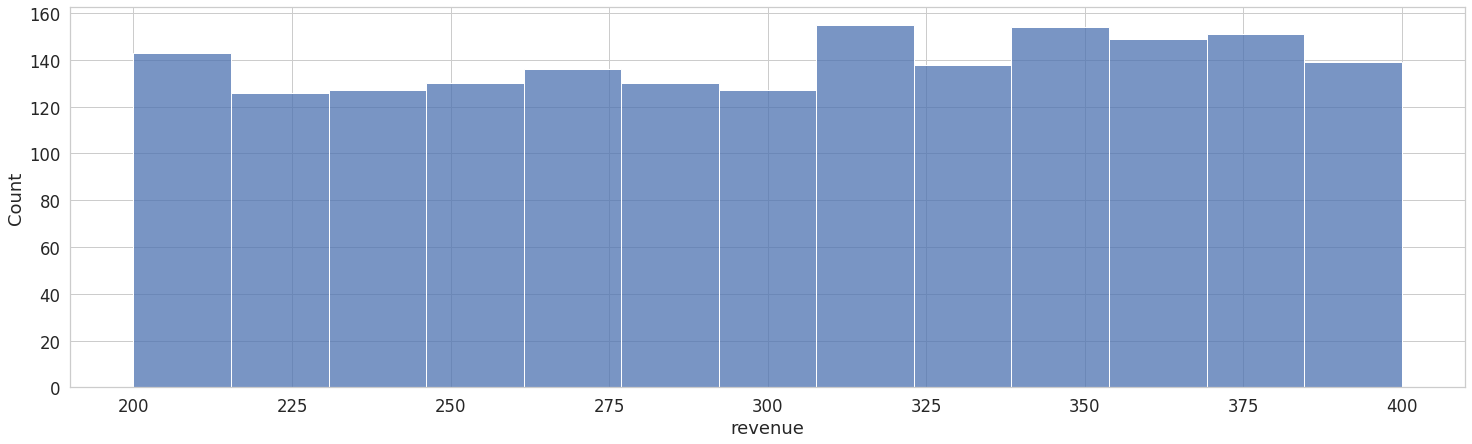

In [26]:
sns.histplot(df_a.loc[df_a['revenue'] < 15000].revenue)
plt.show()

А давайте посмотрим, сколько вообще шейхов оказалось в контрольной группе?

In [27]:
rich_count = df_a.loc[df_a['revenue'] > 15000].user_id.count()
rich_count

123

Сколько их относительно полного числа айди в контрольной группе?

In [28]:
(rich_count / df_a.user_id.count()).round(2)

0.06

6% - это всё-таки весомая цифра, учитвая то, что они приобретают приблизительно на одну сумму, вряд ли случайная. Потому окончательное решение - не выбрасывать "выбросы" и считать вместе с ними.

И ещё. Мы помним, что в контрольной группе больше платящих юезров. Насколько много?

In [29]:
df_a.shape[0] - df_b.shape[0]

123

Интересесно получается! На данный момент можно сделать следующие выводы:
 - в контрольной группе присутсвует кластер щедро платящих пользователей, и в тестовой группе он пропадает.
 - в контрольной группе распределение RPPU  не является равномернвым, в отличие от тестового. Но если убрать из RPPU кластер самых доходных пользователей, окажется, что оставашиеся наблюдения тоже составляют в равномерное распределение. При этом в таком случае RPPU варьируется от 200 до 400 в контрольной группе, тогда как значения в тестовой варьируются от 2000 до 4000
 - среднее в контрольной группе меньше, чем среднее в тестовой: 2663 и 3003 соответсвенно

Настало время статистически проверить разницу в средних. Так как распределения не нормальны, и вообще разные, я использую бутстрап для оценки различий в средних

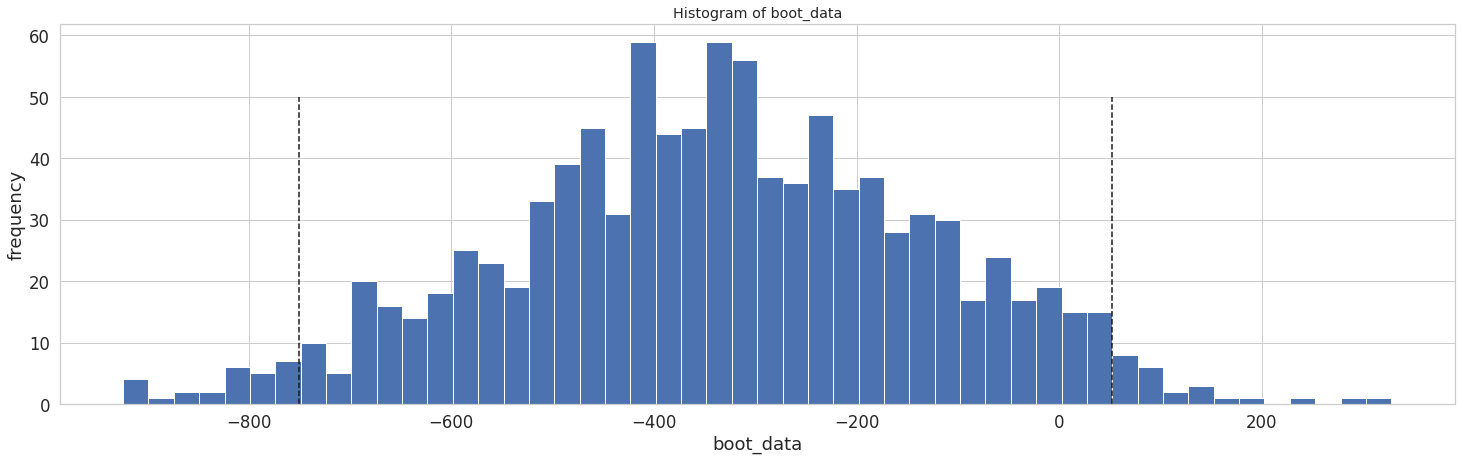

In [30]:
booted_data_mean = get_bootstrap(df_a.revenue, df_b.revenue, statistic = np.mean)

In [31]:
booted_data_mean['ci']

,0
0.025,-750.368400
0.975,51.546966


In [32]:
booted_data_mean['p_value']

0.0

#### Вывод по ARPPU
Согласно методу бутстрап средние(ARPPU) в контрольной и тестовой не различаются, 0 входит в интервал, p<0.01

Для средних различий не было выявлено. Но можно ещё посмотреть на медианы для RPPU - судя по предварительным данным, здесь как раз будут статистически значимые различия

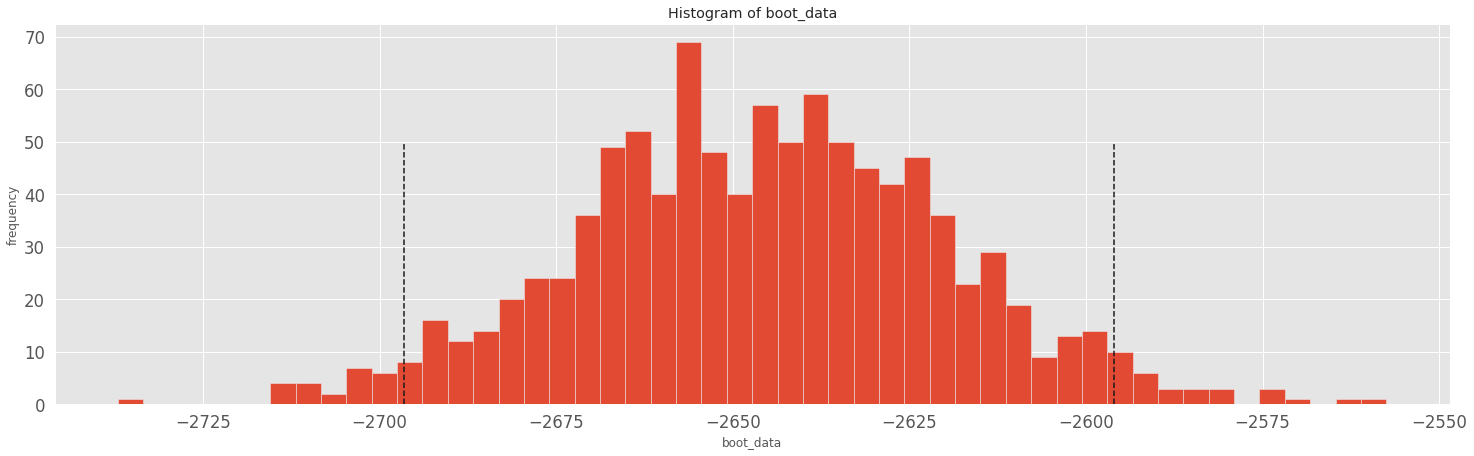

In [33]:
booted_data_median = get_bootstrap(df_a.revenue, df_b.revenue, statistic = np.median)

In [34]:
booted_data_median['ci']

,0
0.025,-2696.5000
0.975,-2595.9875


In [35]:
booted_data_median['p_value']

0.0

#### Вывод по медиане RPPU
Медианы контрольной и тествой групп статистически значимо различаются(0 не входит в интервал, p<0.01). Разница в медианах составляет от 2600 до 2700 в пользу тестовой группы.

### Что было с исходным ARPU?

Теперь мне стало интересно, что получили аналитики исследователи и каким образом. Этот бутстрап я провожу на выборке со всеми пользователями, включая неплавтивших, чтобы вычислить разницу по ARPU.

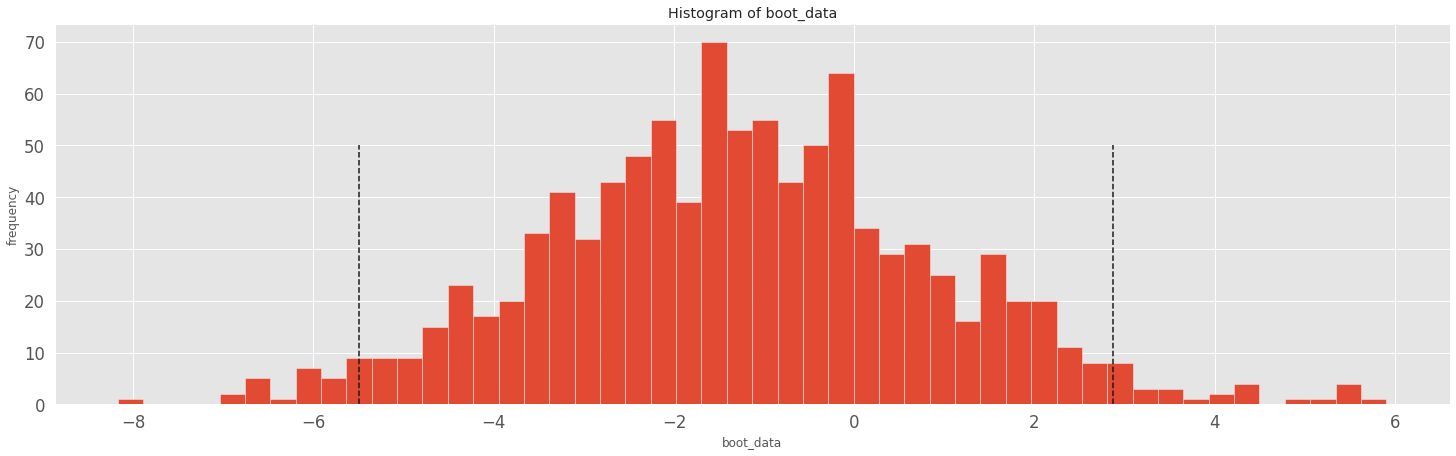

In [36]:
booted_data_mean2 = get_bootstrap(df_ab_test.query('testgroup == "a"').revenue, df_ab_test.query('testgroup == "b"').revenue, statistic = np.mean)

In [37]:
booted_data_mean2['ci']

,0
0.025,-5.499136
0.975,2.869942


In [38]:
booted_data_mean2['p_value']

0.0

#### Вывод по ARPU по полным данным

Интересно получается! Согласно бутстрап, разницы между а и б группой на полных данных по среднему чеку(ARPU) нет! 0 Входит в интервал, p<0.01

Возможно, прошлый аналитик рассчитывал ARPU с вычетом кластера самых доходных пользователей, посчитав их выбросом. Давайте проверим ARPU и для такого случая: уберём их и проведём бутстрап.

In [57]:
df_ab_test_without_outliners = df_ab_test.query('revenue < 15000')

In [63]:
df_a_without_outliners = df_ab_test_without_outliners.query('testgroup == "a"').revenue

In [64]:
df_b_without_outliners = df_ab_test_without_outliners.query('testgroup == "b"').revenue

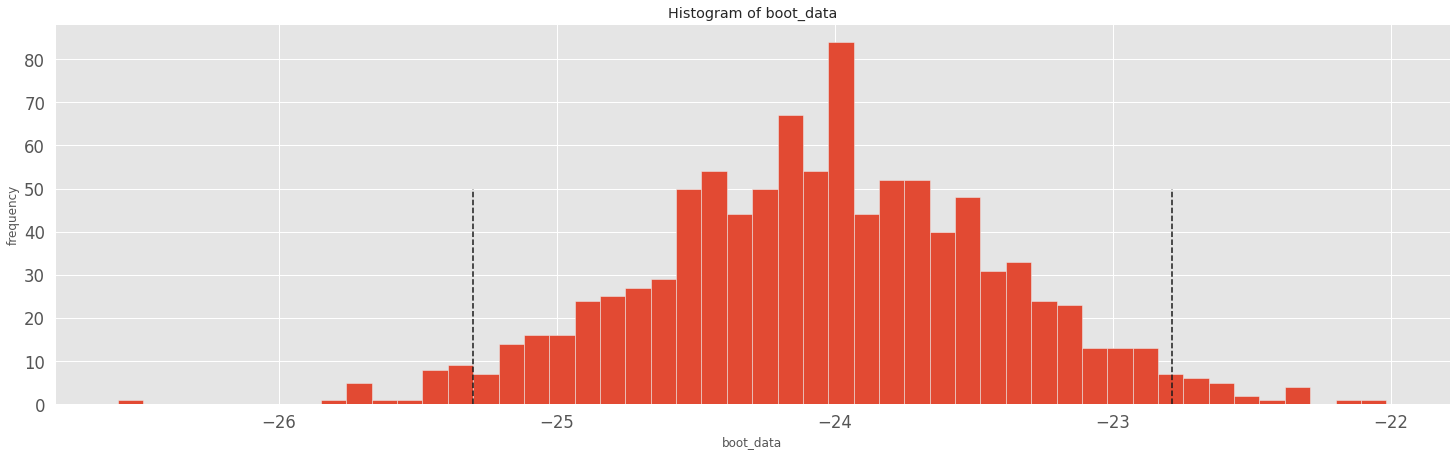

In [67]:
booted_data__without_outliners_mean = get_bootstrap(df_a_without_outliners, df_b_without_outliners , statistic = np.mean)

In [68]:
booted_data__without_outliners_mean['ci']

,0
0.025,-25.302174
0.975,-22.788357


In [69]:
booted_data__without_outliners_mean['p_value']

0.0

#### Вывод по ARPU без "выбросов"

Для такого варианта статистически значимые различия есть, 0 не входит в интервал, p 0.01. Среднее в тестовой больше на 22-25

Какова разница в средних?

In [74]:
df_a_without_outliners.mean()

2.702926032280424

In [75]:
df_b_without_outliners.mean()

26.75128659327863

In [78]:
25 / df_a_without_outliners.mean()

9.249235717674384

Согласно условию, разница в средних была лишь 5%, тогда как по бустрапу получается, что ARPU тестовой примерно в 9 раз больше, ем ARPU контрольной. 

## Окончательный вывод по AB:

**CR в покупателя**

- В контрольной группе есть кластер юзеров, которые платят значительно больше остальных. Этот кластер составляет 6% наблюдений от общего чила наблюдений в контрольной группе. В тестовой группе этот кластер пропадает, остаётся только равномерное распределение более-менее средних покупателей. Разница между числом покупателей в тестовой и контрольной группах статистически значима, проверялась с помощью хи-квадрат.

**ARPPU**
- Контрольная группа включает в себя как кластер средних покупателей, которые заплатили немного, но более-менее одинаково и кластер юзеров, заплативших много. Тестовая группая представляет из себя равномерное распределение, но доход с одного юзера в среднем в 10 раз больше, чем доход со среднего юзера в контрольной выборке (200-400 и 2000-4000).
- Если считать кластер упомянутый выше не выбросом, и оставить данные как есть, бутстрап говорит об отсуствии статистически значимой разницы  для ARPPU по выборкам. 
- Медианы по RPPU различаются, что ожидаемо, в пользу контрольной группы.

**Перепроверка ARPU**
- Так как результаты показались неоднозначными, я решила перепроварить результаты работы прошлого аналитика. Для ARPU по полнным данным бустрап не выявил статистически значимой разницы.
- Для ARPU с исключением из контрольной выборки кластера самых доходных юзеров статистически значимая разница есть, но она не равна 5% : в таком случае средняя тестовой группы примеро в 9 раз выше средней контрольной.

**Что делать?**

**Я считаю, что фичу не нужно выкатывать** : в контрольной группе есть кластер юзеров, которые платят значительно больше остальных, и именно эти наблюдения пропадают: разница между числом покупателей в тестовой и контрольной группах статистически значима, проверялась с помощью хи-квадрат.

ARPPU и ARPU статистически значимо не различаются.

Тут можно добавить, что в тестовой группе выше медиана RPPU, то есть средний пользователь тратит больше, чем в контрольной. Но нужно ли нам это, учитывая то, что вместе с тем пропал кластер самых доходных пользователей? Я считаю, что нет.

### Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

#### Решение:
Для первого условия:

- Метрики времени
Так как для получения награды требуется тратить больше времени в игре, первая метрика, которая приходит в голову - retention. Заинтресованный игрок будет чаще заходить в приложение, больше времени тратить в игре, чтобы добить награду. Сюда же можно отнести такие метрики как DAU, MAU(а лучше его аналог на период, в который длится эвент), ASD, которые тоже напрямую связаны со временем и вовлечённостью пользователя.


- Метрики прибыли
Учитывая то, что нередко игроку не хватает буквально несколько кристалликов или алмазиков, чтобы получить желанный сезонный предмет, можно предположить, что за период акции возрастет количество платящих пользователей, следует обратить внимание на следующие метрики: ARPU, ARPPU, LTV


- Отток пользователей
Churn rate на время эвента может снизиться, так как в игре происходит что-то новое. Можно сравить его как с предыдущими эвентами, так и с периодом вне эвентов(если он есть)

Для второго условия:

Перед перечислением метрик хотела бы описать общий взгляд на ситуацию. Хочу сказать, что считаю, что такое развитие событий слабо повлияет на неплатящих игроков. Если они сначала и постараются играть на таких условиях, скорее всего большая часть из них сдастся после первых неудач. Они не станут платить за то, что не получается. По поводу платящих сказать сложнее.

- Метрики времени
Retention, DAU, MAU(а лучше его аналог на период, в который длится эвент), ASD. 

- Метрики прибыли
ARPPU. Предполагаю, что платящие продолжат платить. А может быть расстроятся и не станут. В любом случае, полезно посмотреть.

- Отток пользователей
Churn rate на время эвента может увеличиться из-за неудач с игрой, так что тоже стоит обратить внимание.